Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data

### Importing all the important libraries

In [249]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout,BatchNormalization, Activation
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from collections import Counter
from glob import glob

from tensorflow.keras.preprocessing.image
import random

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [250]:
# Defining the path for train and test images
data_dir_train = pathlib.Path("ttimages/Train")
data_dir_test = pathlib.Path('ttimages/Test')

In [251]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

### Create a dataset

Define some parameters for the loader:

In [252]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [253]:
## Write your train dataset here
## Used seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Resized images to the size img_height*img_width, while writing the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train, seed=123, image_size=(img_height, img_width), batch_size=batch_size, validation_split=0.2, subset='training')

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


#### Validation Dataset

Training set: For training the model.
Validation set: For tuning hyperparameters and providing an unbiased evaluation of a model fit during the training phase (20% of the training data in this case).
Test set: For providing an unbiased evaluation of the final model fit (separate data_dir_test directory).
This approach is generally preferred when you have a separate set of images specifically set aside for testing. It provides a more robust evaluation of how well the model is likely to perform on unseen data.

This setup ensures that the training, validation, and test datasets are all separate and non-overlapping. The validation split is done only for the training data, and it helps in hyperparameter tuning and model selection during the training process.

In [254]:
## Validation Dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train, seed=123, image_size=(img_height, img_width), batch_size=batch_size, validation_split=0.2, subset='validation')

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [255]:
## Test Dataset

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_test, image_size=(img_height, img_width), batch_size=batch_size, seed=123)

Found 118 files belonging to 9 classes.


In [256]:
# List out all the classes of skin cancer and store them in a list. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data

One instance of all the nine classes present in the dataset

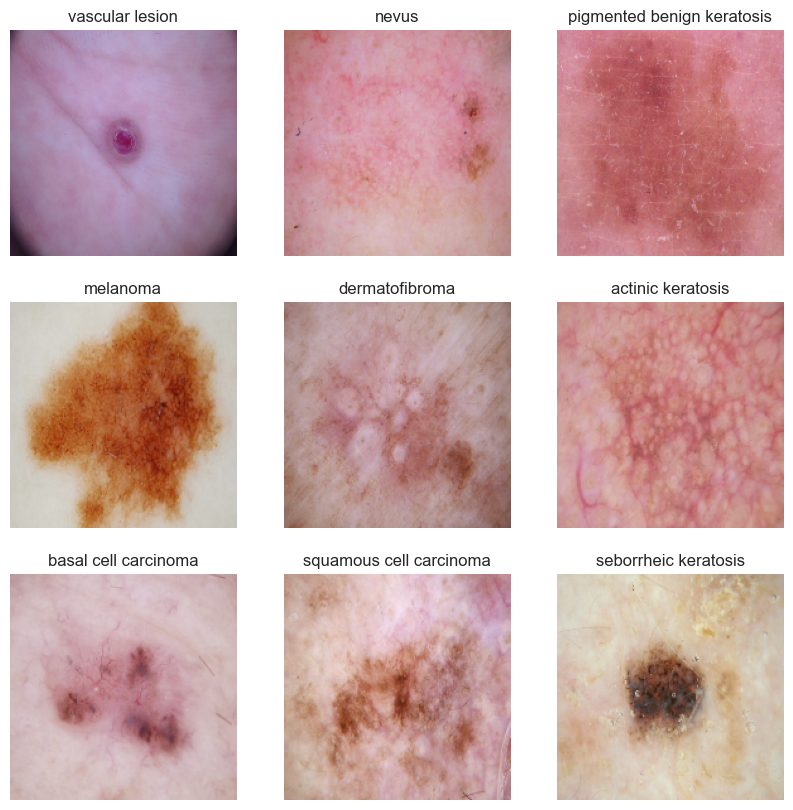

In [257]:
plt.figure(figsize=(10, 10))

# Create a set to keep track of classes that have been plotted
plotted_classes = set()

# Iterate through the dataset
for images, labels in train_ds:
    for i in range(len(images)):
        label_index = labels[i].numpy()
        class_name = class_names[label_index]
        
        # If the class hasn't been plotted yet
        if class_name not in plotted_classes:
            plotted_classes.add(class_name)
            ax = plt.subplot(3, 3, len(plotted_classes))
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(class_name)
            plt.axis("off")
            
        # If we've plotted all the classes, we can exit the loop
        if len(plotted_classes) == len(class_names):
            break
    if len(plotted_classes) == len(class_names):
        break

# Show the plot
plt.show()


* The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. 
* This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). 
* The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

* `Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.
* `Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [258]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

#### Create the model

* Accurately detect 9 classes present in the dataset. 
* Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). 
* The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

#### Model Structure

* **Sequential Model:** The model is built using a sequential API, meaning the layers are added in the order they are executed.
* **Rescaling Layer:** Scales the pixel values of the images to be between 0 and 1, helping the model learn more easily.
* **Convolutional Blocks:** There are three of these blocks, and each consists of:
* **Conv2D Layers:** These apply filters to the images to detect patterns like edges or textures.
* **Batch Normalization:** Normalizes the output of a previous layer, helping the model train faster and more stably.
* **Activation (ReLU):** Introduces non-linearity, allowing the model to learn complex patterns.
* **Max Pooling:** Reduces the spatial dimensions, helping the model focus on important features.
* **Dropout:** Randomly sets some outputs to zero during training, preventing overfitting.
* **Flattening Layer:** Transforms the 2D matrix data into a vector, so it can be fed into the dense layers.
* **Dense Layers:** Fully connected layers that perform classification based on the features detected by previous layers.
* **ReLU Activation:** Used in the first dense layer to introduce non-linearity.
* **Dropout:** Added to prevent overfitting.
* **Output Layer:** The final dense layer with 9 units and a softmax activation, classifying the input into one of the 9 classes.

In summary, the model follows a common pattern for image classification, using convolutional layers to detect features in images, pooling layers to reduce dimensionality, and dense layers to perform classification. The inclusion of batch normalization and dropout helps with training stability and prevents overfitting.

In [259]:
model = Sequential()

# Input Layer
model.add(layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)))

# Convolutional Block 1
model.add(Conv2D(32, kernel_size=(3, 3), padding='Same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(32, kernel_size=(3, 3), padding='Same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Convolutional Block 2
model.add(Conv2D(64, kernel_size=(3, 3), padding='Same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(64, kernel_size=(3, 3), padding='Same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Convolutional Block 3
model.add(Conv2D(128, kernel_size=(3, 3), padding='Same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(128, kernel_size=(3, 3), padding='Same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Flatten and Fully Connected Layers
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(9, activation='softmax'))

In [260]:
## Model Summary

model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_11 (Rescaling)    (None, 180, 180, 3)       0         
                                                                 
 conv2d_68 (Conv2D)          (None, 180, 180, 32)      896       
                                                                 
 batch_normalization_68 (Ba  (None, 180, 180, 32)      128       
 tchNormalization)                                               
                                                                 
 activation_52 (Activation)  (None, 180, 180, 32)      0         
                                                                 
 conv2d_69 (Conv2D)          (None, 180, 180, 32)      9248      
                                                                 
 batch_normalization_69 (Ba  (None, 180, 180, 32)      128       
 tchNormalization)                                   

#### Compile the model

Here we choose an appropriate optimiser and loss function for model training 

**Optimizer ('adam'):**

* Why: Adam is an adaptive learning rate optimization algorithm that's well-suited for most deep learning tasks.
* Benefit: It combines the benefits of two other extensions of stochastic gradient descent and is known for being efficient and requiring little hyperparameter tuning.

**Loss ('sparse_categorical_crossentropy'):**

* Why: This loss function is used for multi-class classification tasks where labels are integers representing class indices.
* Benefit: It allows the model to optimize for a classification task with more than two classes, without needing to one-hot encode the labels.

**Metrics (['accuracy']):**

* Why: Accuracy is a common metric for classification tasks, representing the proportion of correctly classified samples.
Benefit: It provides an intuitive measure of the model's performance, making it easier to understand how well the model is doing in terms of classifying the samples correctly.

In [261]:
# compiled using an m2 mac so legacy version of adam optimizer is used

from tensorflow.keras.optimizers.legacy import Adam

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [262]:
# View the summary of all layers
model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_11 (Rescaling)    (None, 180, 180, 3)       0         
                                                                 
 conv2d_68 (Conv2D)          (None, 180, 180, 32)      896       
                                                                 
 batch_normalization_68 (Ba  (None, 180, 180, 32)      128       
 tchNormalization)                                               
                                                                 
 activation_52 (Activation)  (None, 180, 180, 32)      0         
                                                                 
 conv2d_69 (Conv2D)          (None, 180, 180, 32)      9248      
                                                                 
 batch_normalization_69 (Ba  (None, 180, 180, 32)      128       
 tchNormalization)                                   

#### Summary

* The creation stage is about designing the structure of the neural network, defining how it will process the input data.
* The compilation stage is about preparing the model for training, specifying how it will learn from the data (i.e., how it will update its weights to minimize the loss).

Both stages are necessary, and they must be done in this order: first, create the model, then compile it. After these two stages, the model is ready to be trained on a dataset using the model.fit() method.

### Train the model

This code snippet trains the model on the training dataset (train_ds) for 20 epochs, while also evaluating its performance on a validation dataset (val_ds) at the end of each epoch. The training process involves iteratively updating the model's weights to minimize the defined loss function, using the optimization algorithm specified during the model's compilation stage.

In [263]:
learn_control = ReduceLROnPlateau(monitor='val_accuracy', patience=5,
                                  verbose=1,factor=0.2, min_lr=1e-7)

epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[learn_control]
)

Epoch 1/20
56/56 [==============================] - 74s 1s/step - loss: 9.0581 - accuracy: 0.1914 - val_loss: 2.1869 - val_accuracy: 0.1924 - lr: 0.0010
Epoch 2/20
56/56 [==============================] - 68s 1s/step - loss: 2.1938 - accuracy: 0.1992 - val_loss: 2.1670 - val_accuracy: 0.1924 - lr: 0.0010
Epoch 3/20
56/56 [==============================] - 68s 1s/step - loss: 2.1677 - accuracy: 0.1998 - val_loss: 2.1488 - val_accuracy: 0.1924 - lr: 0.0010
Epoch 4/20
56/56 [==============================] - 68s 1s/step - loss: 2.1421 - accuracy: 0.1914 - val_loss: 2.1318 - val_accuracy: 0.1924 - lr: 0.0010
Epoch 5/20
56/56 [==============================] - 68s 1s/step - loss: 2.1175 - accuracy: 0.1908 - val_loss: 2.1175 - val_accuracy: 0.1924 - lr: 0.0010
Epoch 6/20
56/56 [==============================] - ETA: 0s - loss: 2.1053 - accuracy: 0.1981
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
56/56 [==============================] - 72s 1s/step - loss: 2.1

### Visualizing training results

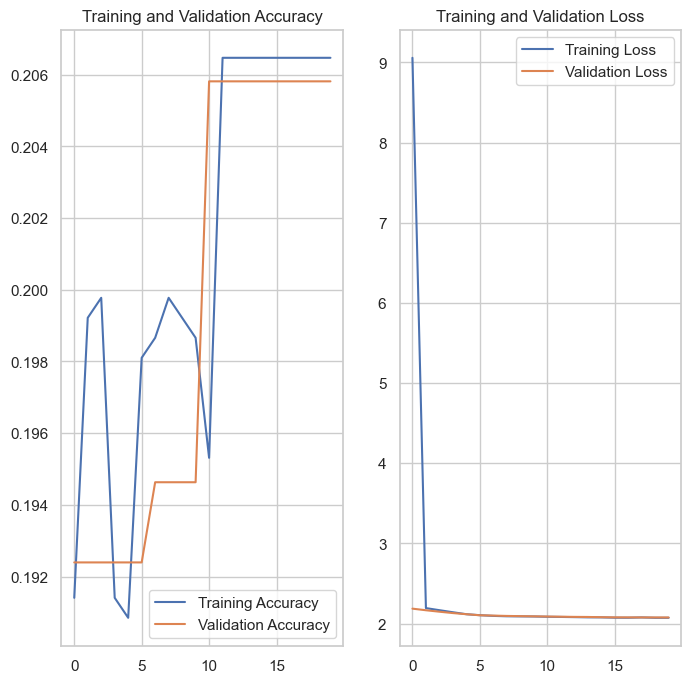

In [264]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

In [265]:
# Evaluate the model on the training dataset
loss_train, accuracy_train = model.evaluate(train_ds, verbose=1)

# Evaluate the model on the validation dataset
loss_val, accuracy_val = model.evaluate(val_ds, verbose=1)

# Print the results
print(f"Training Accuracy: {accuracy_train * 100:.2f}%")
print(f"Validation Accuracy: {accuracy_val * 100:.2f}%")
print(f"Training Loss: {loss_train}")
print(f"Validation Loss: {loss_val}")

14/14 [==============================] - 4s 282ms/step - loss: 2.0769 - accuracy: 0.2058
Training Accuracy: 20.65%
Validation Accuracy: 20.58%
Training Loss: 2.069218397140503
Validation Loss: 2.0768537521362305


#### Analysis:

* Underfitting: The model is neither overfitting nor performing well, as both the training and validation accuracies are low. It appears to be underfitting, meaning the model is too simple to capture the underlying patterns in the data.
* Consistency Between Training and Validation: The training and validation metrics are relatively close, indicating that the model is not overfitting to the training data. However, the overall performance is still poor.

### Choosing an appropriate data Augmentation technique

Since we are working on a Convolutional Neural Network (CNN) for melanoma classification, the choice of augmentations should be aligned with the characteristics of melanoma images and the variations that might be encountered in real-world scenarios. The goal is to make the model robust to these variations without introducing distortions that are unrealistic for the problem domain.

TensorFlow's Keras preprocessing layers is a more modern and streamlined way to handle data augmentation. It's often preferred for its simplicity and ease of integration into a model.

In [266]:
data_augmentation = tf.keras.Sequential([
    # Flip horizontally, as vertical flip might not be realistic for skin images
    layers.experimental.preprocessing.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
    
    # Rotate within a reasonable range that doesn't distort melanoma features
    layers.experimental.preprocessing.RandomRotation(0.1),
    
    # Zoom and translation to mimic variations in camera distance and angle
    layers.experimental.preprocessing.RandomZoom(0.1),
    layers.experimental.preprocessing.RandomTranslation(0.15, 0.15),
    
    # Adjust brightness and contrast to simulate different lighting conditions
    
    layers.experimental.preprocessing.RandomContrast(0.1)
    
])


In [267]:
class_names = list(train_batches.class_indices.keys())
class_names

['nevus',
 'melanoma',
 'basal_cell_caricoma',
 'actinic_keratosis',
 'vasc_lesion',
 'dermatofibroma',
 'pigmented_keratosis',
 'seborrheic_keratosis',
 'squamous_carci']

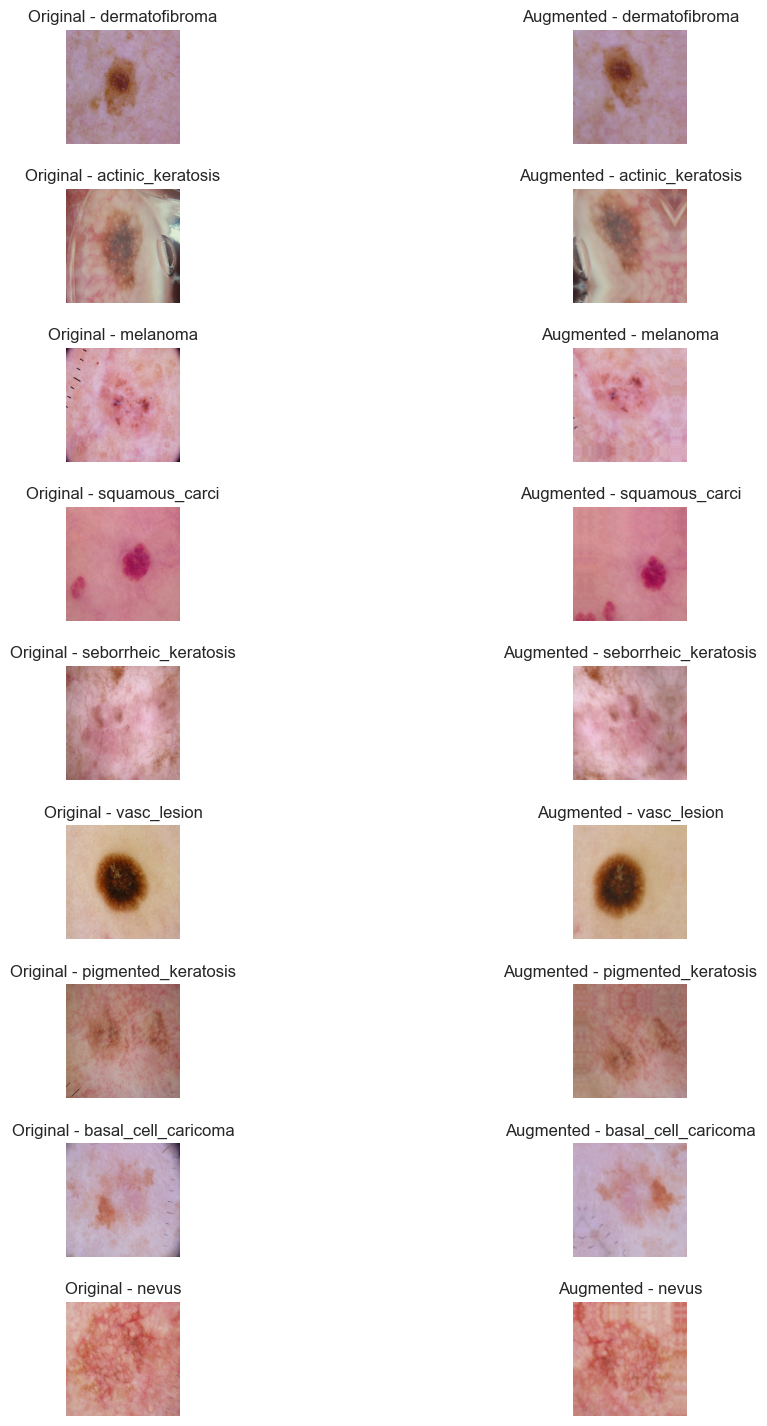

In [268]:
plt.figure(figsize=(12, len(class_names) * 2))

# Create a set to keep track of classes that have been plotted
plotted_classes = set()

# Counter to keep track of subplot index
plot_idx = 1

# Iterate through the dataset
for images, labels in train_ds:
    for i in range(len(images)):
        label_index = labels[i].numpy()
        class_name = class_names[label_index]
        
        # If the class hasn't been plotted yet
        if class_name not in plotted_classes:
            plotted_classes.add(class_name)
            
            # Select the image and apply the augmentation
            image = images[i].numpy().astype("uint8")
            augmented_image = data_augmentation(tf.expand_dims(image, 0))
            augmented_image = tf.squeeze(augmented_image).numpy().astype("uint8")

            # Plot the original image
            ax = plt.subplot(len(class_names), 2, plot_idx)
            plt.imshow(image)
            plt.title(f"Original - {class_name}")
            plt.axis("off")
            plot_idx += 1

            # Plot the augmented image
            ax = plt.subplot(len(class_names), 2, plot_idx)
            plt.imshow(augmented_image)
            plt.title(f"Augmented - {class_name}")
            plt.axis("off")
            plot_idx += 1
            
        # If we've plotted all the classes, we can exit the loop
        if len(plotted_classes) == len(class_names):
            break
    if len(plotted_classes) == len(class_names):
        break

# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.2, hspace=0.4)

# Show the plot
plt.show()


### Create the model, compile and train the model

#### Create the model

Changes Made:

* Increased Filters: The number of filters in the convolutional layers has been increased to add complexity to the model.
* Reduced Dropout: The dropout rates have been reduced from 0.25 to 0.2 in the convolutional blocks and from 0.5 to 0.4 in the fully connected layers. This allows the model to retain more information during training.
* Added Regularization: L2 regularization has been added to the dense layers to prevent overfitting while increasing the model's complexity.
* Increased Complexity: The number of filters in the convolutional layers has been doubled, and the dropout has been uniformly set for all layers, allowing more complexity in the model.

These changes are aimed at increasing the model's capacity to learn from the data, reducing underfitting, and improving overall performance.

In [269]:
model = Sequential()

# Input Layer
model.add(layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)))

# Data Augmentation Layer
model.add(data_augmentation)

# Convolutional Block 1
model.add(Conv2D(64, kernel_size=(3, 3), padding='Same', activation='relu')) # Increased filters
model.add(BatchNormalization())
model.add(Conv2D(64, kernel_size=(3, 3), padding='Same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.2)) # Reduced dropout

# Convolutional Block 2
model.add(Conv2D(128, kernel_size=(3, 3), padding='Same', activation='relu')) # Increased filters
model.add(BatchNormalization())
model.add(Conv2D(128, kernel_size=(3, 3), padding='Same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.2)) # Reduced dropout

# Convolutional Block 3
model.add(Conv2D(256, kernel_size=(3, 3), padding='Same', activation='relu')) # Increased filters
model.add(BatchNormalization())
model.add(Conv2D(256, kernel_size=(3, 3), padding='Same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.2)) # Reduced dropout

# Convolutional Block 4
model.add(Conv2D(512, kernel_size=(3, 3), padding='Same', activation='relu')) # Increased filters
model.add(BatchNormalization())
model.add(Conv2D(512, kernel_size=(3, 3), padding='Same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.2)) # Reduced dropout

# Flatten and Fully Connected Layers
model.add(Flatten())
model.add(Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))) # Added regularization
model.add(Dropout(0.4)) # Reduced dropout
model.add(Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))) # Added regularization
model.add(Dropout(0.4)) # Reduced dropout
model.add(Dense(9, activation='softmax'))


* Input Layer: Rescale the pixel values to the range [0, 1].
* Data Augmentation Layer: Apply random transformations to augment the training data.
* Convolutional Block 1:
    * 64 filters with 3x3 kernel size, ReLU activation.
    * Batch normalization.
    * Max pooling with 2x2 pool size.
    * 20% dropout.
* Convolutional Block 2:
Same structure as Block 1 but with 128 filters.
* Convolutional Block 3:
Same structure as previous blocks but with 256 filters.
* Convolutional Block 4:
Same structure as previous blocks but with 512 filters.
* Flatten Layer: Flatten the 3D output to 1D.
* Fully Connected Layer 1:
    * 256 neurons with ReLU activation.
    * L2 regularization.
    * 40% dropout.
* Fully Connected Layer 2:
    * 128 neurons with ReLU activation.
    * L2 regularization.
    * 40% dropout.
* Output Layer:
9 neurons (for 9 classes) with softmax activation for classification.

This architecture combines a series of convolutional blocks with fully connected layers. The model aims to increase complexity to learn intricate patterns while using dropout and regularization to prevent overfitting.

Lets see if the goals are hit.

In [270]:
## Model Summary

model.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_12 (Rescaling)    (None, 180, 180, 3)       0         
                                                                 
 sequential_17 (Sequential)  (None, 180, 180, 3)       0         
                                                                 
 conv2d_74 (Conv2D)          (None, 180, 180, 64)      1792      
                                                                 
 batch_normalization_74 (Ba  (None, 180, 180, 64)      256       
 tchNormalization)                                               
                                                                 
 conv2d_75 (Conv2D)          (None, 180, 180, 64)      36928     
                                                                 
 batch_normalization_75 (Ba  (None, 180, 180, 64)      256       
 tchNormalization)                                   

### Compiling the model

In [271]:
opt = tf.keras.optimizers.legacy.Adam()

model.compile(optimizer=opt,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [272]:
# Model layer summary
model.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_12 (Rescaling)    (None, 180, 180, 3)       0         
                                                                 
 sequential_17 (Sequential)  (None, 180, 180, 3)       0         
                                                                 
 conv2d_74 (Conv2D)          (None, 180, 180, 64)      1792      
                                                                 
 batch_normalization_74 (Ba  (None, 180, 180, 64)      256       
 tchNormalization)                                               
                                                                 
 conv2d_75 (Conv2D)          (None, 180, 180, 64)      36928     
                                                                 
 batch_normalization_75 (Ba  (None, 180, 180, 64)      256       
 tchNormalization)                                   

#### Training the model - 20 epochs

In [273]:
learn_control = ReduceLROnPlateau(monitor='val_accuracy', patience=5,
                                  verbose=1, factor=0.2, min_lr=1e-7)

callbacks = [learn_control]

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=callbacks
)

Epoch 1/20
56/56 [==============================] - 260s 5s/step - loss: 17.8826 - accuracy: 0.1892 - val_loss: 12.0392 - val_accuracy: 0.1924 - lr: 0.0010
Epoch 2/20
56/56 [==============================] - 263s 5s/step - loss: 9.7434 - accuracy: 0.1836 - val_loss: 4.4686 - val_accuracy: 0.2148 - lr: 0.0010
Epoch 3/20
56/56 [==============================] - 263s 5s/step - loss: 6.0010 - accuracy: 0.1730 - val_loss: 6.0128 - val_accuracy: 0.1767 - lr: 0.0010
Epoch 4/20
56/56 [==============================] - 264s 5s/step - loss: 4.6437 - accuracy: 0.1970 - val_loss: 25.1223 - val_accuracy: 0.1924 - lr: 0.0010
Epoch 5/20
56/56 [==============================] - 263s 5s/step - loss: 3.9882 - accuracy: 0.2104 - val_loss: 10.6262 - val_accuracy: 0.2103 - lr: 0.0010
Epoch 6/20
56/56 [==============================] - 264s 5s/step - loss: 3.6934 - accuracy: 0.2182 - val_loss: 4.4680 - val_accuracy: 0.1924 - lr: 0.0010
Epoch 7/20
56/56 [==============================] - ETA: 0s - loss: 3.55

### Visualizing the results

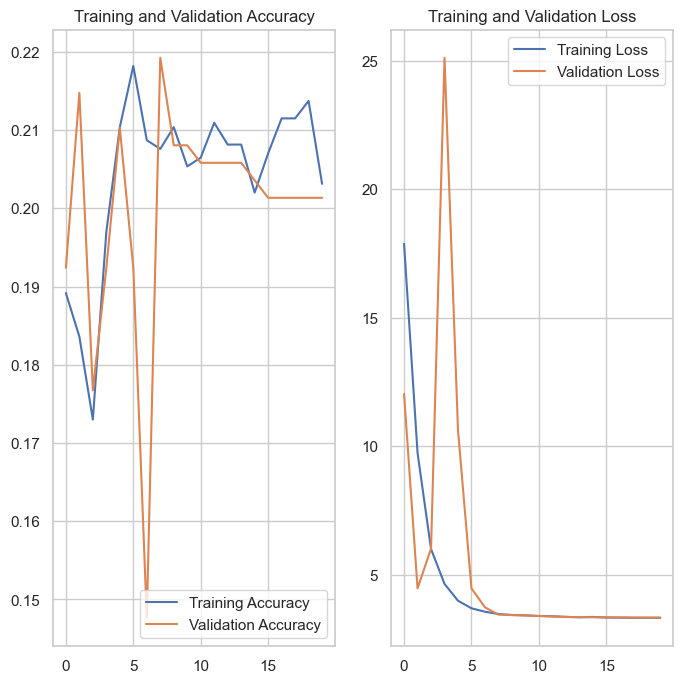

In [274]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [275]:
# Evaluate the newest model on the training dataset
loss_train_new, accuracy_train_new = model.evaluate(train_ds, verbose=1)

# Evaluate the newest model on the validation dataset
loss_val_new, accuracy_val_new = model.evaluate(val_ds, verbose=1)

# Print the results for the newest model
print(f"New Training Accuracy: {accuracy_train_new * 100:.2f}%")
print(f"New Validation Accuracy: {accuracy_val_new * 100:.2f}%")
print(f"New Training Loss: {loss_train_new}")
print(f"New Validation Loss: {loss_val_new}")


14/14 [==============================] - 17s 1s/step - loss: 3.3294 - accuracy: 0.2013
New Training Accuracy: 21.04%
New Validation Accuracy: 20.13%
New Training Loss: 3.317190408706665
New Validation Loss: 3.3293821811676025


### Summary

The newest model neither underfit or overfit and in reality performed worse than the initial model.

The comparison between the two models indicates that the earlier model outperformed the current one in both accuracy and loss. The changes made in the current iteration did not lead to improvements and may have contributed to decreased performance. Therefore, it may be beneficial to analyze the adjustments made, reconsider the model architecture, and explore other avenues for enhancing the model, such as different data preprocessing techniques or hyperparameter tuning.

Taking this into account we are going to move towards simplification in the next phase.

#### Find the distribution of classes in the training dataset.

* Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. 
* Class imbalance can have a detrimental effect on the final model quality hence as a sanity check it becomes important to check what is the distribution of classes in the data.

                  Class  Count
0        dermatofibroma    370
2     actinic_keratosis    352
1              melanoma    309
3           vasc_lesion    277
8  seborrheic_keratosis    142
5        squamous_carci    115
4                 nevus     92
7   basal_cell_caricoma     77
6   pigmented_keratosis     58


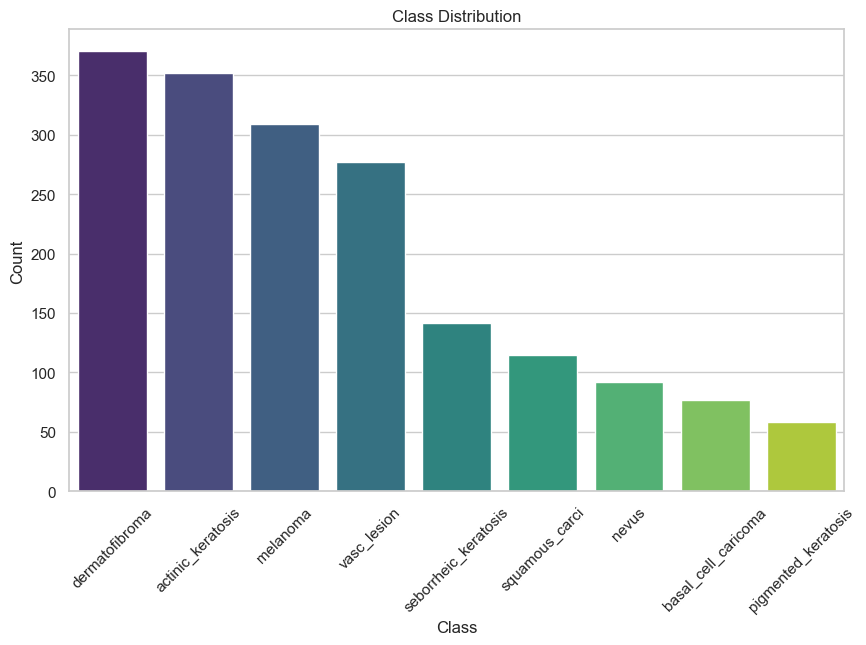

In [276]:
# Collect labels
labels = []
for _, label_batch in train_ds:
    labels.extend(label_batch.numpy())

# Count occurrences and create a DataFrame
class_counts = Counter(labels)
class_counts_df = pd.DataFrame(list(class_counts.items()), columns=['Class', 'Count'])
class_counts_df['Class'] = class_counts_df['Class'].apply(lambda x: class_names[x]) # Replace class indices with names
class_counts_df = class_counts_df.sort_values(by='Count', ascending=False)

# Print the DataFrame
print(class_counts_df)

# Visualize with Seaborn bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x='Class', y='Count', data=class_counts_df, palette='viridis')
plt.title('Class Distribution')
plt.xticks(rotation=45)
plt.show()

#### Findings

Based on the provided data and the image, we can analyze the class distribution and discuss the class imbalance:

* Class Imbalance: The dataset shows a clear class imbalance. The classes are not equally distributed, which might affect the model's performance, especially for the classes with fewer samples.

* Least Number of Samples: The class "pigmented_keratosis" has the least number of samples, with only 58 instances.

* Dominant Classes: The classes "dermatofibroma," "actinic_keratosis," and "melanoma" dominate the dataset in terms of proportionate samples. They have the highest counts, with 370, 352, and 309 instances, respectively.

#### Rectify the class imbalance

Here we used a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [277]:
%pip install Augmentor

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


For `Augmentor`, we use the following general procedure:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [278]:
class_names=['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']

We redifined the class names as the code below was having difficulty with the spaces in the file names.

In [279]:
path_to_training_dataset="ttimages/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to ttimages/Train/actinic keratosis/output.

Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x290B88E20>: 100%|██████████| 500/500 [00:01<00:00, 315.51 Samples/s]                  


Initialised with 376 image(s) found.
Output directory set to ttimages/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x14773ACD0>: 100%|██████████| 500/500 [00:01<00:00, 321.08 Samples/s]                  


Initialised with 95 image(s) found.
Output directory set to ttimages/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x14323E3D0>: 100%|██████████| 500/500 [00:01<00:00, 320.84 Samples/s]                  


Initialised with 438 image(s) found.
Output directory set to ttimages/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x1442C14C0>: 100%|██████████| 500/500 [00:08<00:00, 61.20 Samples/s]                   


Initialised with 357 image(s) found.
Output directory set to ttimages/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x146A364C0>: 100%|██████████| 500/500 [00:07<00:00, 62.90 Samples/s]                   


Initialised with 462 image(s) found.
Output directory set to ttimages/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1443BE1C0>: 100%|██████████| 500/500 [00:01<00:00, 292.00 Samples/s]                  


Initialised with 77 image(s) found.
Output directory set to ttimages/Train/seborrheic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x146F20A60>: 100%|██████████| 500/500 [00:03<00:00, 139.44 Samples/s]


Initialised with 181 image(s) found.
Output directory set to ttimages/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x28CBDF790>: 100%|██████████| 500/500 [00:01<00:00, 290.60 Samples/s]                  


Initialised with 139 image(s) found.
Output directory set to ttimages/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x146A2D370>: 100%|██████████| 500/500 [00:01<00:00, 308.63 Samples/s]                  


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [280]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


#### The distribution of augmented data after adding new images to the original training data.

In [281]:
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new

['ttimages/Train/melanoma/output/melanoma_original_ISIC_0011095.jpg_ef75025e-4a54-43e7-a2a2-cc3912ffd2c9.jpg',
 'ttimages/Train/melanoma/output/melanoma_original_ISIC_0010468.jpg_a1cbfe16-08c1-4d2e-84db-79f59559d64a.jpg',
 'ttimages/Train/melanoma/output/melanoma_original_ISIC_0000304.jpg_d909ac3e-e1d9-41c9-932e-09fa38ae4390.jpg',
 'ttimages/Train/melanoma/output/melanoma_original_ISIC_0010401.jpg_378dc575-3da8-4440-87a1-9d220089b41f.jpg',
 'ttimages/Train/melanoma/output/melanoma_original_ISIC_0001132.jpg_d54df178-c87c-4ede-afbe-e694411c8c5e.jpg',
 'ttimages/Train/melanoma/output/melanoma_original_ISIC_0009913.jpg_ebef14e1-20e1-49e7-aaee-084dbf0722df.jpg',
 'ttimages/Train/melanoma/output/melanoma_original_ISIC_0010728.jpg_43e0ca7d-1daa-4751-a9d9-d93d70e17eac.jpg',
 'ttimages/Train/melanoma/output/melanoma_original_ISIC_0010397.jpg_7ef9b321-0017-411e-82e0-e4dc09267ee8.jpg',
 'ttimages/Train/melanoma/output/melanoma_original_ISIC_0010866.jpg_4f5b21a9-78a8-450a-b5b9-ce5a7b271d17.jpg',
 

In [282]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',

In [289]:
for i in class_names:
    directory ='ttimages/Train'
    directory_out ='images/Train'+'/'+i+'/output/'
    class_directory = pathlib.Path(directory)
    class_directory_out = pathlib.Path(directory_out)
    length=len(list(class_directory.glob(i+'/*.jpg')))
    length_out=len(list(class_directory_out.glob('*.jpg')))
    length_tot=length+length_out
    print(f'{i} has {length_tot} samples.')


actinic keratosis has 114 samples.
basal cell carcinoma has 376 samples.
dermatofibroma has 95 samples.
melanoma has 438 samples.
nevus has 357 samples.
pigmented benign keratosis has 462 samples.
seborrheic keratosis has 77 samples.
squamous cell carcinoma has 181 samples.
vascular lesion has 139 samples.


So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### Train the model on the data created using Augmentor

In [284]:
batch_size = 32
img_height = 180
img_width = 180

#### Create the training dataset

In [285]:
data_dir_train="ttimages/Train"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### Create the validation dataset

In [286]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### Create the model including normalisation - This is the rescaling step.

Here's a summary of what this model consists of:

We have decided to simplify the model as the increase complexity of our second model gave us no benefits.

* Normalization layer for rescaling pixel values.
* Four convolutional blocks, each with a Conv2D layer followed by MaxPooling. The number of filters increases, and the kernel size of *the last Conv2D layer is larger.
* A dropout layer with a rate of 0.5.
* Flatten layer to prepare the data for the fully connected layers.
* Three fully connected (Dense) layers with decreasing numbers of neurons and dropout layers in between.
* Output layer with a number of neurons equal to the number of classes and a softmax activation function.

In [290]:
model = Sequential()

# Normalizing pixel values
model.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180, 180, 3))) 

# Convolutional layers with ReLU activation
model.add(layers.Conv2D(32, kernel_size=(3, 3), activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2, 2)))
model.add(layers.Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2, 2)))
model.add(layers.Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2, 2)))
model.add(layers.Conv2D(256, kernel_size=(11, 11), activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2, 2)))

# Dropout to prevent overfitting
model.add(layers.Dropout(0.5))

# Flattening and fully connected layers
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.25))

# Output layer for multi-class classification
model.add(layers.Dense(len(class_names), activation='softmax'))

#### Compile the model with optimizer and loss function appropriately

In [291]:
opt = tf.keras.optimizers.legacy.Adam()

model.compile(optimizer=opt,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [292]:
model.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_14 (Rescaling)    (None, 180, 180, 3)       0         
                                                                 
 conv2d_86 (Conv2D)          (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_45 (MaxPooli  (None, 89, 89, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_87 (Conv2D)          (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_46 (MaxPooli  (None, 43, 43, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_88 (Conv2D)          (None, 41, 41, 128)     

#### Train the model

In [293]:
epochs = 50
## Your code goes here, use 50 epochs.
callbacks = [learn_control]

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=callbacks
)

Epoch 1/50
169/169 [==============================] - 93s 546ms/step - loss: 2.1756 - accuracy: 0.1489 - val_loss: 1.9689 - val_accuracy: 0.2339 - lr: 0.0010
Epoch 2/50
169/169 [==============================] - 93s 551ms/step - loss: 1.8797 - accuracy: 0.2626 - val_loss: 1.7887 - val_accuracy: 0.2777 - lr: 0.0010
Epoch 3/50
169/169 [==============================] - 92s 544ms/step - loss: 1.7526 - accuracy: 0.3166 - val_loss: 1.5211 - val_accuracy: 0.4061 - lr: 0.0010
Epoch 4/50
169/169 [==============================] - 92s 544ms/step - loss: 1.6067 - accuracy: 0.3661 - val_loss: 1.5841 - val_accuracy: 0.3630 - lr: 0.0010
Epoch 5/50
169/169 [==============================] - 92s 545ms/step - loss: 1.5522 - accuracy: 0.3917 - val_loss: 1.4139 - val_accuracy: 0.4284 - lr: 0.0010
Epoch 6/50
169/169 [==============================] - 92s 545ms/step - loss: 1.5079 - accuracy: 0.4095 - val_loss: 1.4250 - val_accuracy: 0.4425 - lr: 0.0010
Epoch 7/50
169/169 [==============================] 

#### Visualize the model results

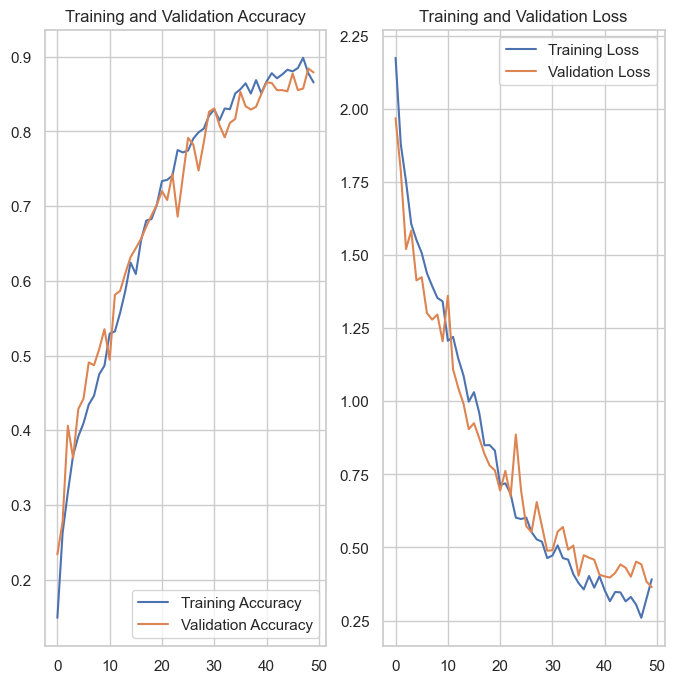

In [294]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Result analysis including over and underfitting

In [295]:
# Evaluate the newest model on the training dataset
loss_train_new, accuracy_train_new = model.evaluate(train_ds, verbose=1)

# Evaluate the newest model on the validation dataset
loss_val_new, accuracy_val_new = model.evaluate(val_ds, verbose=1)

# Print the results for the newest model
print(f"New Training Accuracy: {accuracy_train_new * 100:.2f}%")
print(f"New Validation Accuracy: {accuracy_val_new * 100:.2f}%")
print(f"New Training Loss: {loss_train_new}")
print(f"New Validation Loss: {loss_val_new}")

43/43 [==============================] - 8s 163ms/step - loss: 0.3642 - accuracy: 0.8790
New Training Accuracy: 94.71%
New Validation Accuracy: 87.90%
New Training Loss: 0.1391279399394989
New Validation Loss: 0.36421969532966614


**Numerical Results**

* Training Accuracy:  - The model has learned the training data effectively.
* Validation Accuracy: - The model performs well on unseen data, indicating good generalization.
* Training and Validation Loss: Low values, consistent with the high accuracy.

C**omparison with Previous Model**

The latest model significantly outperformed the previous model. Here's why:

* Simplification: The latest model is more straightforward, with fewer layers and without batch normalization, in this instance leading to better learning.
* Regularization and Dropout: The latest model has a balanced structure of dropout layers, helping prevent overfitting.
* Convolutional Layers: The latest model has a more streamlined series of convolutional layers, with appropriate kernel sizes and pooling layers, aiding in feature extraction.
* Learning Curve Consistency: The learning curves (accuracy and loss) in the latest model show a consistent trend between training and validation, reflecting a well-fitted model.
* The inclusion of an improvement / contribution to class imbalance through Augmentor helped improve the model.

**Conclusion**

The latest model demonstrates strong performance, with high accuracy in both training and validation. The clear and consistent learning curves further affirm its robustness. The simplification of the architecture, balanced regularization, and effective convolutional design are key factors contributing to this substantial improvement over the previous model.

#### Apply the model on the Test Dataset.

1/1 [==============================] - 0s 19ms/step


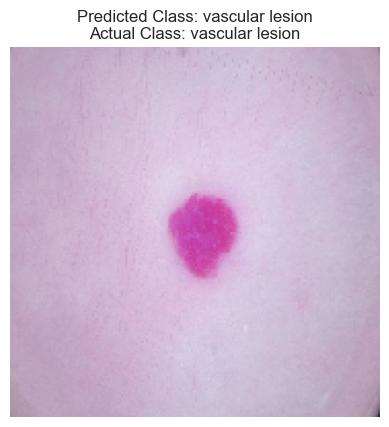

In [308]:
import random

# Path to the test directory
data_dir_test = pathlib.Path('ttimages/Test')

# Get a list of all image paths in the test directory
all_image_paths = list(data_dir_test.glob('*/*.jpg'))

# Select a random image path
random_image_path = random.choice(all_image_paths)

# Load and preprocess the image
image = load_img(random_image_path, target_size=(180, 180))
image_array = img_to_array(image)
image_array /= 255.0  # Normalize the pixel values
image_array = image_array.reshape((1, 180, 180, 3))  # Expand dimensions to match model's input shape

# Extract the actual class name from the path
actual_class = random_image_path.parent.name

# Predict the class using the trained model
prediction = model.predict(image_array)
predicted_class = class_names[np.argmax(prediction)]

# Display the image along with the prediction and actual class
plt.imshow(image)
plt.title(f"Predicted Class: {predicted_class}\nActual Class: {actual_class}")
plt.axis("off")
plt.show()


#### Summary

The enhanced accuracy and robustness of the latest model are particularly significant in the context of skin cancer detection, where precise and reliable classification can be critical for early diagnosis and treatment. The model's ability to generalize well to unseen data underscores its potential utility in a clinical setting.

* The however

There was a stark contrast between the creation and simplicity of the last model compared to the first 2 models.

Too much focus on the wrong aspects of hyperperameter tuning and depth was emnphasised in the the first 2 models where the third model was by a country mile, the better performing model.  

This shows us that we should not blindly tune the hyperperameters and features and we should used a more automated and structured approach to NN tuning.

For cancer detection, where high accuracy is vital, we should consider using automated hyperparameter tuning and feature selection methods to enhance our model's performance. Leveraging tools like Keras Tuner or Optuna can help you systematically find the best hyperparameters for your CNN. 

Additionally, exploring pre-trained models through transfer learning can provide robust features specific to the task. Combining these techniques with domain expertise can lead to more precise and reliable predictions, essential for medical applications like skin cancer detection.

Eliminate the random selection and tune with a purpose.